In [ ]:
import os
import pandas as pd
import geopandas as gpd
import plotly.express as px
import ast
%pylab inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 40000)
pd.set_option('display.max_rows', None)
 
df_safegraph_poi = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_POI_Yellowstone_200miRadius.csv.gz'))
df_safegraph_spend = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_SPEND_Yellowstone_200miRadius.csv.gz'))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
mask = df_safegraph_poi['CITY'] == 'Gardiner'
df_gardiner_poi = df_safegraph_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_gardiner = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_gardiner_poi['PLACEKEY'])]
else:
    print("Error: DataFrame does not contain 'PLACEKEY' column.")

print(df_gardiner.head(10))

                 PLACEKEY                        SAFEGRAPH_BRAND_IDS                               BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLI

## Functions

In [5]:
def time_filt(df, start, end):
    datetime_start = pd.to_datetime(start)
    datetime_end = pd.to_datetime(end)
    df_copy = df.copy()
    
    df_copy['SPEND_DATE_RANGE_START'] = pd.to_datetime(df_copy['SPEND_DATE_RANGE_START'])
    df_copy['SPEND_DATE_RANGE_END'] = pd.to_datetime(df_copy['SPEND_DATE_RANGE_END'])
    
    df_filtered = df_copy[(df_copy['SPEND_DATE_RANGE_START'] >= datetime_start) &
                                 (df_copy['SPEND_DATE_RANGE_END'] <= datetime_end)]
    
    return df_filtered


In [6]:
def percent_instate(df):
    home_city = df['CUSTOMER_HOME_CITY']
    in_state = 0
    out_state = 0

    for val in df['CUSTOMER_HOME_CITY']:
        cities = val.split(",")
        cities = cities[1::2]
        for i in cities:
            state = i.split(':')
            if(state[0].find("MT") != 1):
                count = state[1].strip("{}")
                out_state += int(count)
            else:
                count = state[1].strip("{}")
                in_state += int(count)
    
    print('Out of state: ', out_state)
    print('In state: ', in_state)
    print('Percentage out of state:', (out_state)/(in_state+out_state)*100, '%')
    
    return [in_state, out_state]

In [7]:
def percent_change_month(df):
    pct_change_month = df['SPEND_PCT_CHANGE_VS_PREV_MONTH'].dropna()
    
    sum = 0
    product = 1
    for val in pct_change_month:
        sum += val/100
        product *= val/100
    pct_change_total = (sum + product)*100
    return pct_change_total

In [8]:
def percent_change_year(df):
    pct_change_year = df['SPEND_PCT_CHANGE_VS_PREV_YEAR'].dropna()
    
    sum = 0
    product = 1
    for val in pct_change_year:
        sum += val/100
        product *= val/100
    pct_change_total = (sum + product)*100
    return pct_change_total

In [9]:
def spend_by_day(df):
    df_filtered = df.copy()

    # Convert string representations of lists in 'SPEND_BY_DAY' to actual lists
    df_filtered['SPEND_BY_DAY'] = df_filtered['SPEND_BY_DAY'].apply(ast.literal_eval)

    # Add a new column called 'DATE_OF_MONTH', as a list of integers from 1 to the end of the month (length of the 'SPEND_BY_DAY' list)
    df_filtered['DATE_OF_MONTH'] = df_filtered['SPEND_BY_DAY'].apply(lambda x: list(range(1, len(x) + 1)))

    df_spend_by_day = df_filtered.explode(['SPEND_BY_DAY', 'DATE_OF_MONTH'])

    df_spend_by_day['SPEND_BY_DAY'] = df_spend_by_day['SPEND_BY_DAY'].astype(float)
    df_spend_by_day['DATE_OF_MONTH'] = df_spend_by_day['DATE_OF_MONTH'].astype(int)

    df_spend_by_day['DATE'] = pd.to_datetime(df_spend_by_day['SPEND_DATE_RANGE_START']) + pd.to_timedelta(df_spend_by_day['DATE_OF_MONTH'] - 1, unit='D')

    df_grouped = df_spend_by_day.groupby('DATE')['SPEND_BY_DAY'].sum()

    return df_grouped

## General Gardiner, MT

In [10]:
df_gardiner_flood = time_filt(df_gardiner, '2022-05-01', '2022-08-01')
df_flood_spending = spend_by_day(df_gardiner_flood)

before_flood = df_flood_spending[33:40]
during_flood = df_flood_spending[40:47]
after_flood = df_flood_spending[47:54]
print(before_flood)
print(during_flood)
print(after_flood)

DATE
2022-06-03    1945.55
2022-06-04    1016.28
2022-06-05    2234.91
2022-06-06    2820.89
2022-06-07    2027.16
2022-06-08    2709.08
2022-06-09    1491.84
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    2341.30
2022-06-11    1712.47
2022-06-12    2394.36
2022-06-13    9480.20
2022-06-14    1440.85
2022-06-15     240.77
2022-06-16     323.34
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    284.54
2022-06-18    196.34
2022-06-19     45.59
2022-06-20    479.02
2022-06-21    132.56
2022-06-22    251.44
2022-06-23    165.52
Name: SPEND_BY_DAY, dtype: float64


Text(0.5, 0.98, 'Daily Spending: Gardiner, MT')

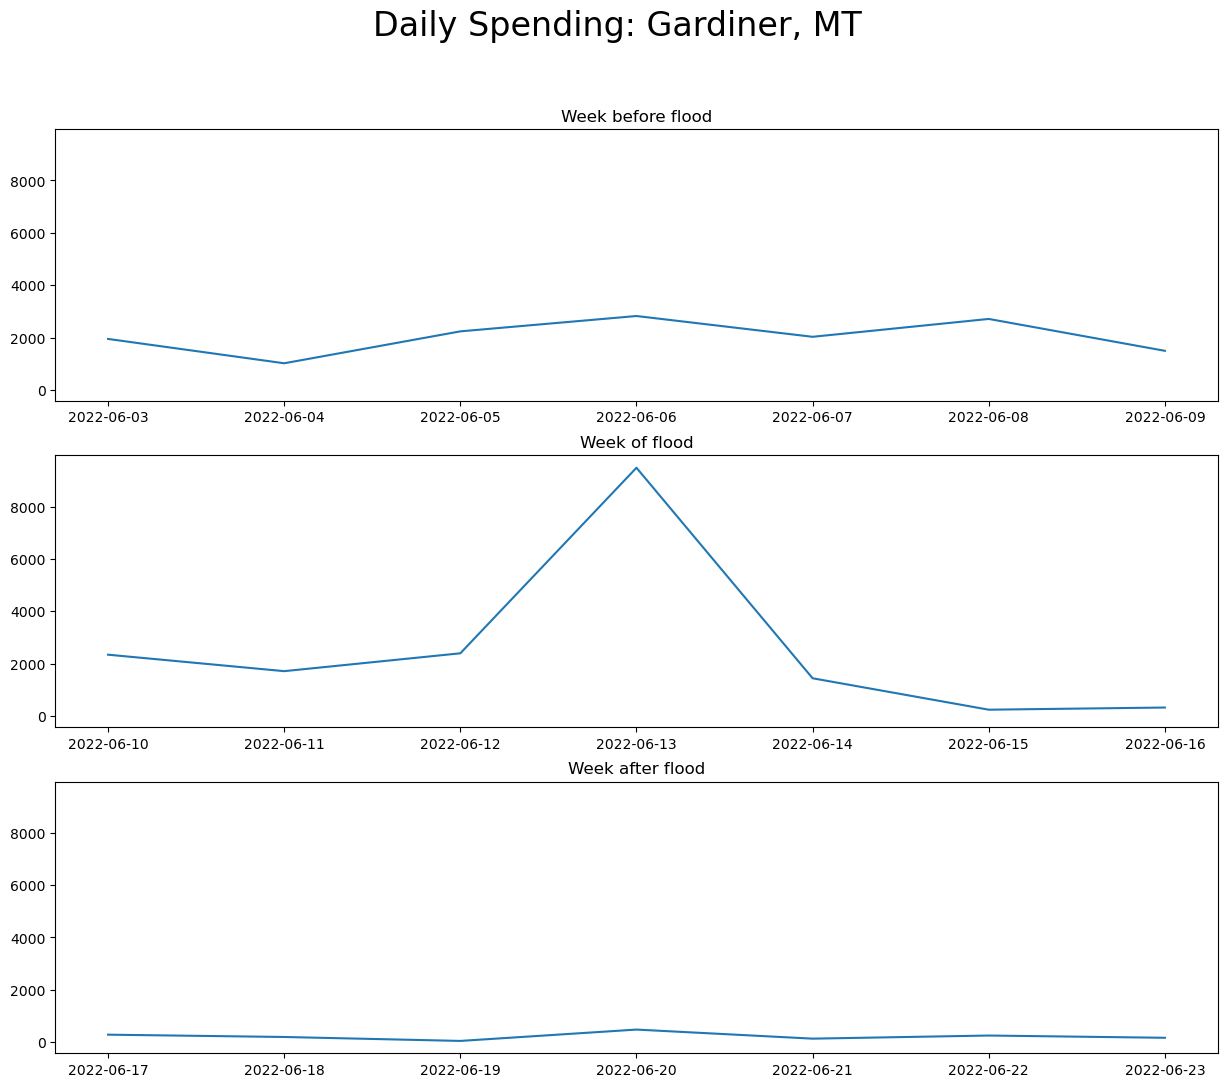

In [ ]:
fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood)
ax1.set_title('Week before flood');
ax2.plot(during_flood)
ax2.set_title('Week of flood');
ax3.plot(after_flood)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending: Gardiner, MT', fontsize='24');

In [14]:
before_flood_start = '2022-05-01'
before_flood_end = '2022-06-01'

df_gardiner_before = time_filt(df_gardiner, before_flood_start, before_flood_end)


In [15]:
during_flood_start = '2022-06-01'
during_flood_end = '2022-07-01'

df_gardiner_during = time_filt(df_gardiner, during_flood_start, during_flood_end)

In [16]:
after_flood_start = '2022-07-01'
after_flood_end = '2022-08-01'

df_gardiner_after = time_filt(df_gardiner, after_flood_start, after_flood_end)
print(df_gardiner_after)

                   PLACEKEY                        SAFEGRAPH_BRAND_IDS                               BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND           TRANSACTION_INTERMEDIARY           SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CRO

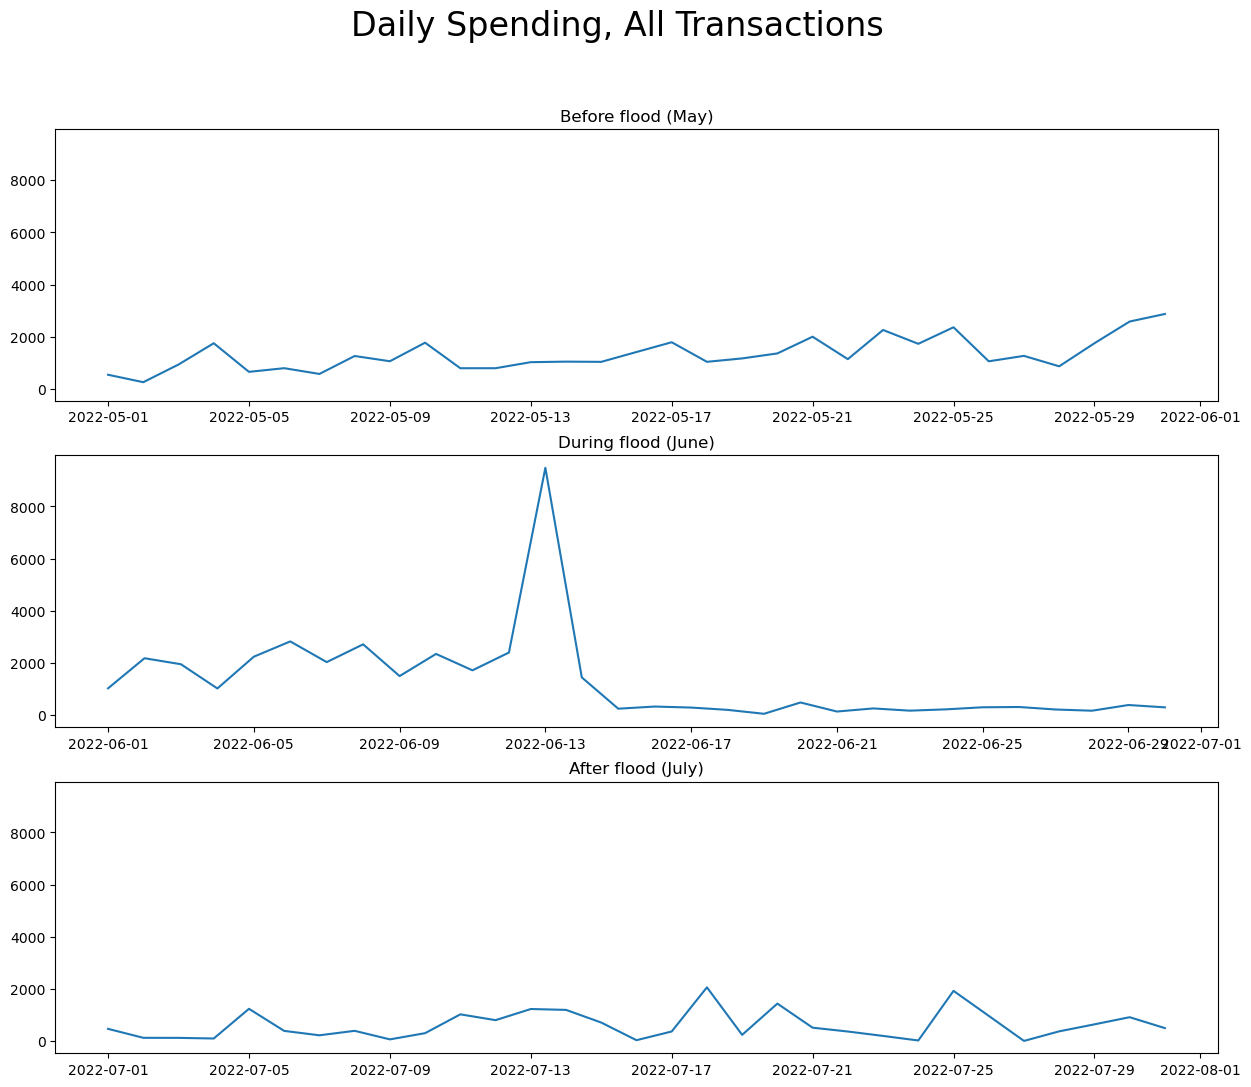

In [17]:
df_spend_before = spend_by_day(df_gardiner_before)
df_spend_during = spend_by_day(df_gardiner_during)
df_spend_after = spend_by_day(df_gardiner_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(df_spend_before)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, All Transactions', fontsize='24');

In [ ]:
df_spend = spend_by_day

In [13]:
print('Percent Change April to May: ')
print(percent_change_month(df_gardiner_before), '%\n')

print('Percent Change May to Jume: ')
print(percent_change_month(df_gardiner_during), '%\n')

print('Percent Change June to July: ')
print(percent_change_month(df_gardiner_after), '%\n')

Percent Change April to May: 
268332063.10952488 %

Percent Change May to Jume: 
395.99999633911506 %

Percent Change June to July: 
-364.0 %



In [14]:
print('Percent Change May 2021 to May 2022: ')
print(percent_change_year(df_gardiner_before), '%\n')

print('Percent Change June 2021 to Jume 2022: ')
print(percent_change_year(df_gardiner_during), '%\n')

print('Percent Change July 2021 to July 2022: ')
print(percent_change_year(df_gardiner_after), '%\n')

Percent Change May 2021 to May 2022: 
108.99994408193403 %

Percent Change June 2021 to Jume 2022: 
-290.99105399412764 %

Percent Change July 2021 to July 2022: 
-553.4437374744214 %



Before Flooding: 
Out of state:  891
In state:  88
Percentage out of state: 91.01123595505618 %


During Flooding: 
Out of state:  749
In state:  85
Percentage out of state: 89.80815347721823 %


After Flooding: 
Out of state:  201
In state:  64
Percentage out of state: 75.84905660377359 %




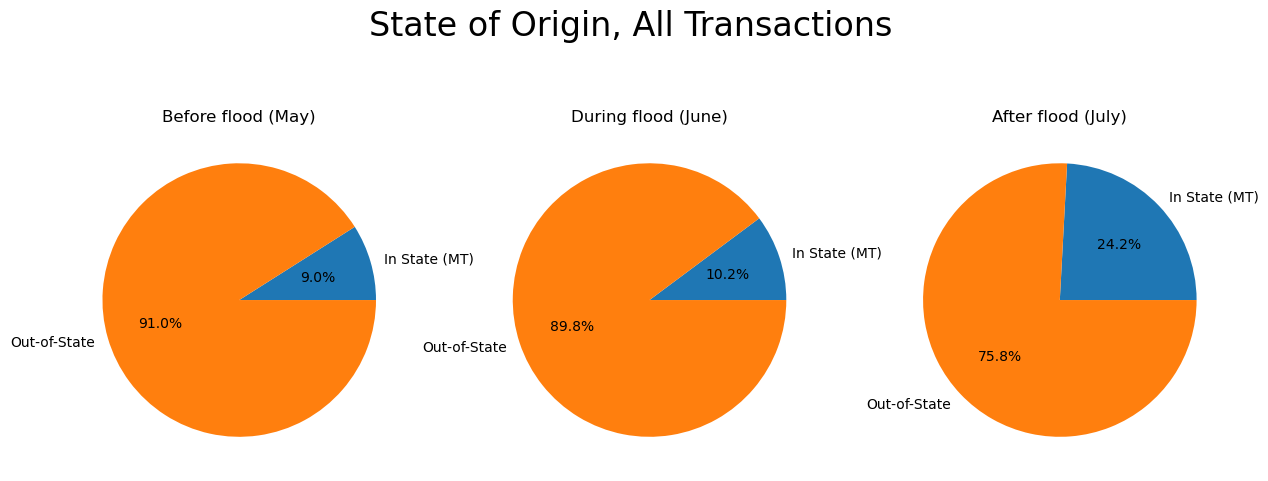

In [15]:
print('Before Flooding: ')
before = percent_instate(df_gardiner_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_gardiner_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_gardiner_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));
ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');

fig.suptitle('State of Origin, All Transactions', fontsize='24');

In [16]:
month = ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', 
         '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01']

df_gardiner_jan = time_filt(df_gardiner, month[0], month[1])
df_gardiner_feb = time_filt(df_gardiner, month[1], month[2])
df_gardiner_mar = time_filt(df_gardiner, month[2], month[3])
df_gardiner_apr = time_filt(df_gardiner, month[3], month[4])
df_gardiner_may = time_filt(df_gardiner, month[4], month[5])
df_gardiner_jun = time_filt(df_gardiner, month[5], month[6])
df_gardiner_jul = time_filt(df_gardiner, month[6], month[7])
df_gardiner_aug = time_filt(df_gardiner, month[7], month[8])
df_gardiner_sep = time_filt(df_gardiner, month[8], month[9])
df_gardiner_oct = time_filt(df_gardiner, month[9], month[10])
df_gardiner_nov = time_filt(df_gardiner, month[10], month[11])
df_gardiner_dec = time_filt(df_gardiner, month[11], month[12])

month_dfs = [df_gardiner_jan, df_gardiner_feb, df_gardiner_mar, df_gardiner_apr, df_gardiner_may, df_gardiner_jun, 
             df_gardiner_jul, df_gardiner_aug, df_gardiner_sep, df_gardiner_oct, df_gardiner_nov, df_gardiner_dec]

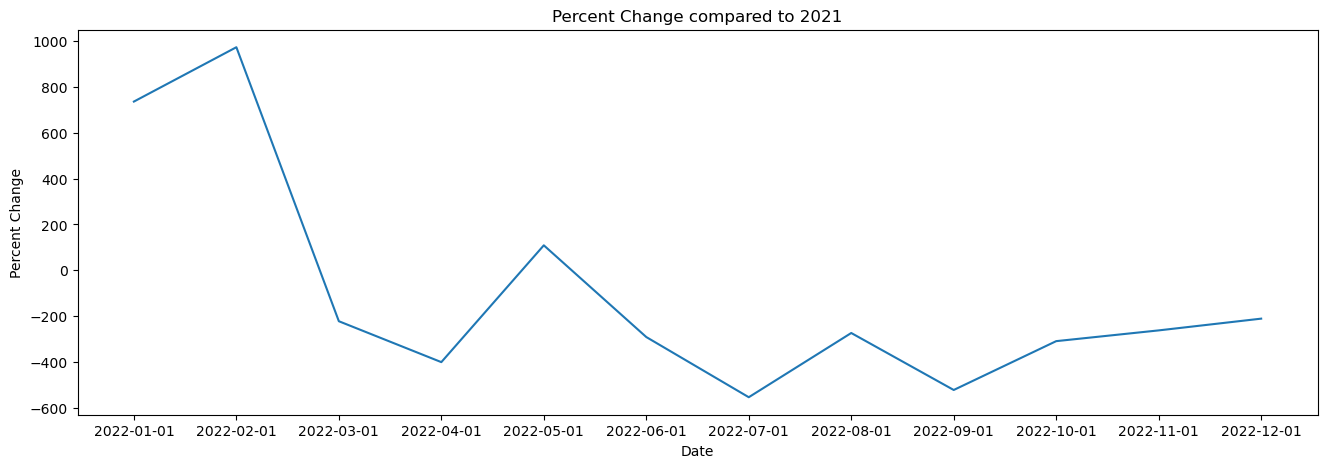

In [17]:
prev_year_pct=[]

for i in range(0, len(month_dfs)):
    prev_year_pct.append(percent_change_year(month_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

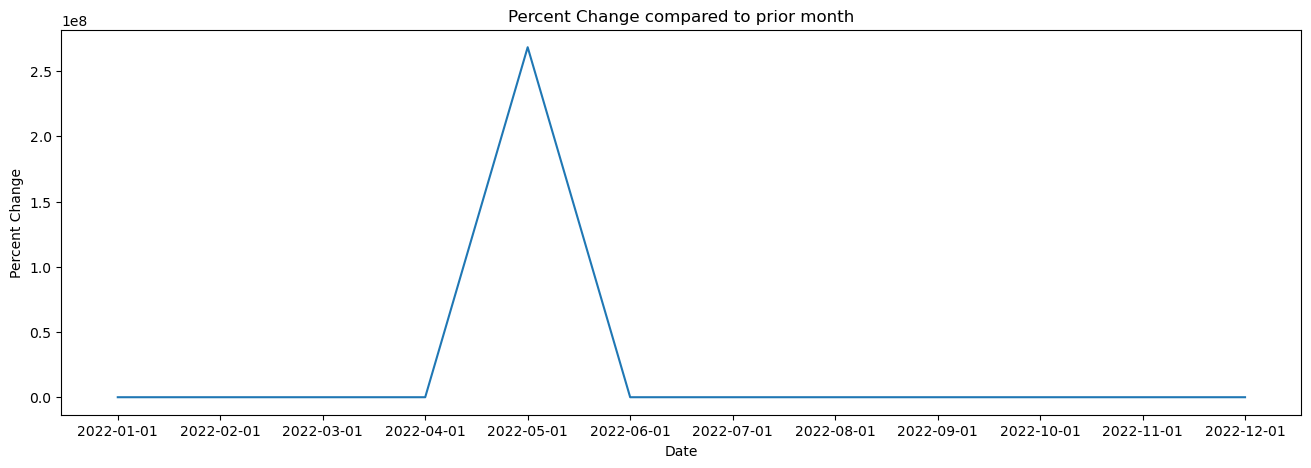

In [18]:
prev_month_pct=[]

for i in range(0, len(month_dfs)):
    prev_month_pct.append(percent_change_month(month_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Gardiner Accomodations

In [18]:
accomodation_naics = '721'
mask = [ str(ncode)[:3]==accomodation_naics for ncode in list(df_gardiner_poi['NAICS_CODE']) ]
df_hotels_pois = df_gardiner_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_gardiner_hotels = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_hotels_pois['PLACEKEY'])]

df_hotel_before = time_filt(df_gardiner_hotels, before_flood_start, before_flood_end)
print(df_hotel_before.head(5), '\n')

df_hotel_during = time_filt(df_gardiner_hotels, during_flood_start, during_flood_end)
print(df_hotel_during.head(5), '\n')

df_hotel_after = time_filt(df_gardiner_hotels, after_flood_start, after_flood_end)
print(df_hotel_after.head(5), '\n')

                   PLACEKEY                        SAFEGRAPH_BRAND_IDS      BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_C

DATE
2022-06-03     229.48
2022-06-04       0.00
2022-06-05    1114.84
2022-06-06     275.16
2022-06-07     242.91
2022-06-08      63.86
2022-06-09     582.62
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    939.12
2022-06-11      0.00
2022-06-12    297.68
2022-06-13      0.00
2022-06-14    465.66
2022-06-15      0.00
2022-06-16      0.00
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    0.0
2022-06-18    0.0
2022-06-19    0.0
2022-06-20    0.0
2022-06-21    0.0
2022-06-22    0.0
2022-06-23    0.0
Name: SPEND_BY_DAY, dtype: float64


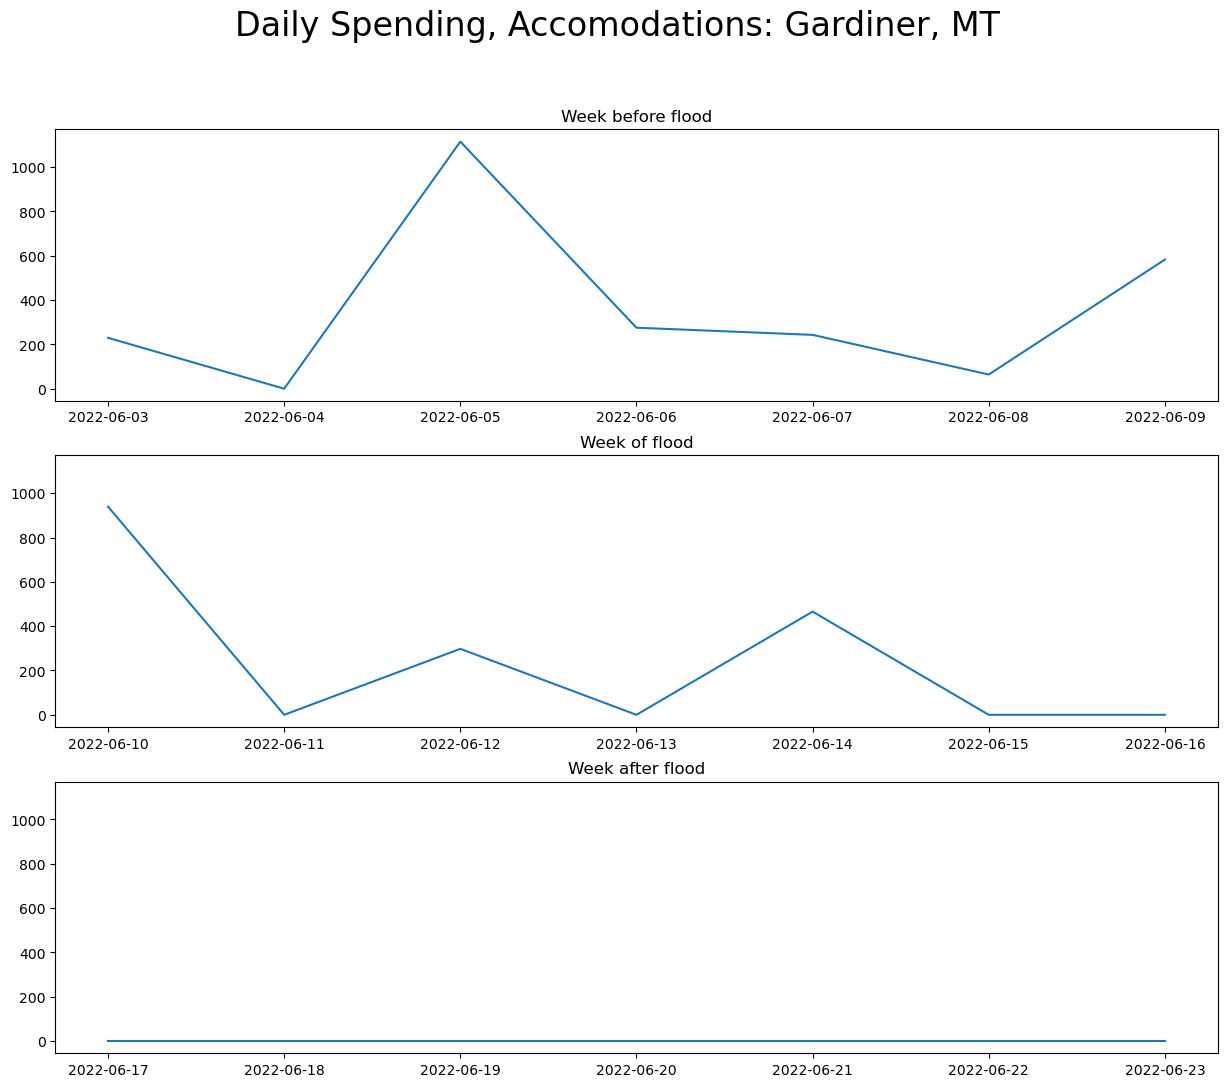

In [24]:
df_hotel_flood = time_filt(df_gardiner_hotels, '2022-05-01', '2022-08-01')
df_flood_spending_hotels = spend_by_day(df_hotel_flood)

before_flood_hotels = df_flood_spending_hotels[33:40]
during_flood_hotels = df_flood_spending_hotels[40:47]
after_flood_hotels = df_flood_spending_hotels[47:54]
print(before_flood_hotels)
print(during_flood_hotels)
print(after_flood_hotels)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_hotels)
ax1.set_title('Week before flood');
ax2.plot(during_flood_hotels)
ax2.set_title('Week of flood');
ax3.plot(after_flood_hotels)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Accomodations: Gardiner, MT', fontsize='24');

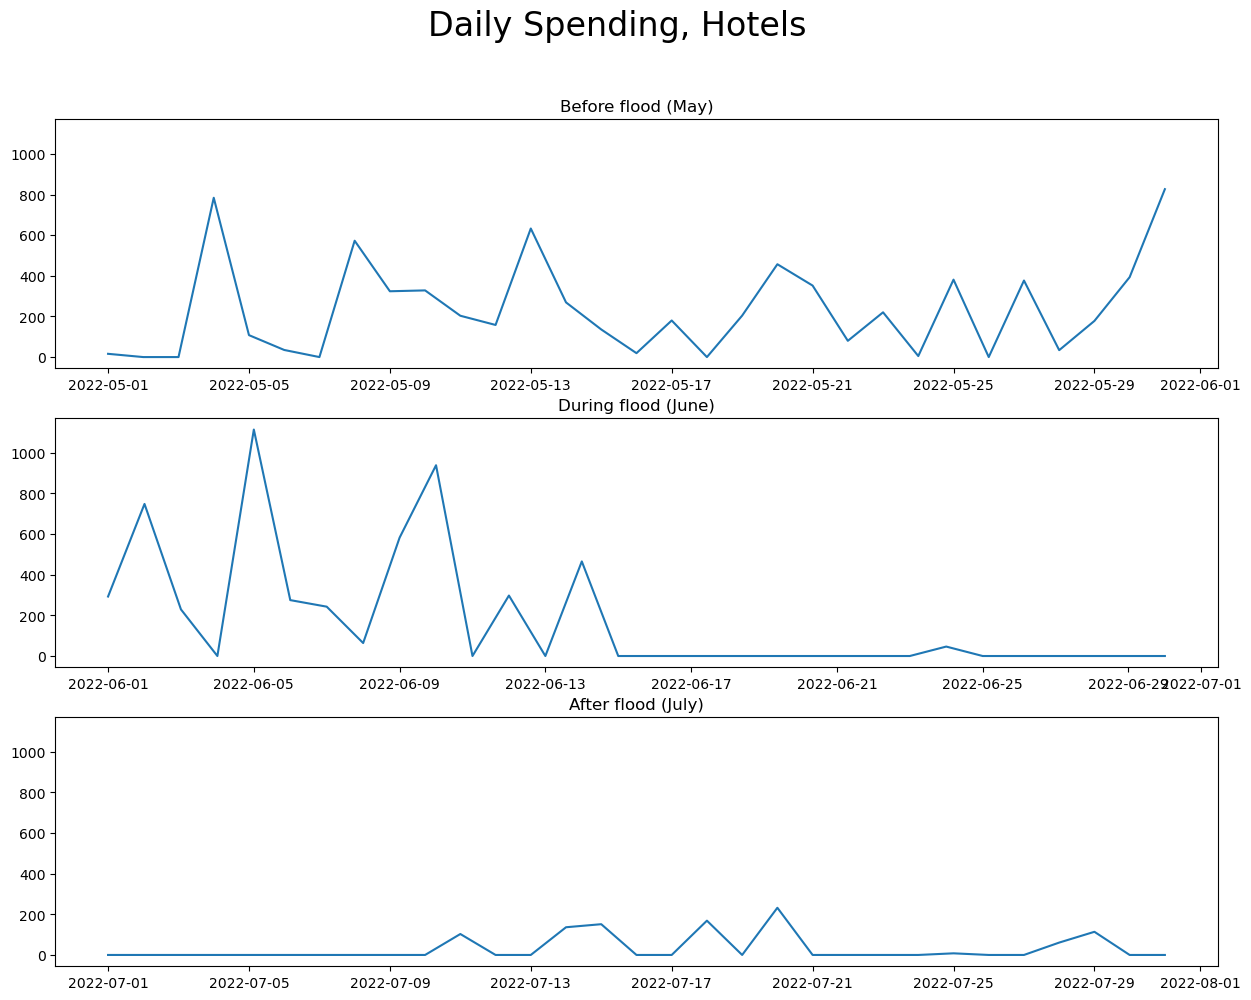

In [20]:
df_spend_before_hotel = spend_by_day(df_hotel_before)
df_spend_during_hotel = spend_by_day(df_hotel_during)
df_spend_after_hotel = spend_by_day(df_hotel_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_hotel)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_hotel)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_hotel)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Hotels', fontsize='24');

Before Flooding: 
Out of state:  70
In state:  10
Percentage out of state: 87.5 %


During Flooding: 
Out of state:  39
In state:  4
Percentage out of state: 90.69767441860465 %


After Flooding: 
Out of state:  18
In state:  2
Percentage out of state: 90.0 %




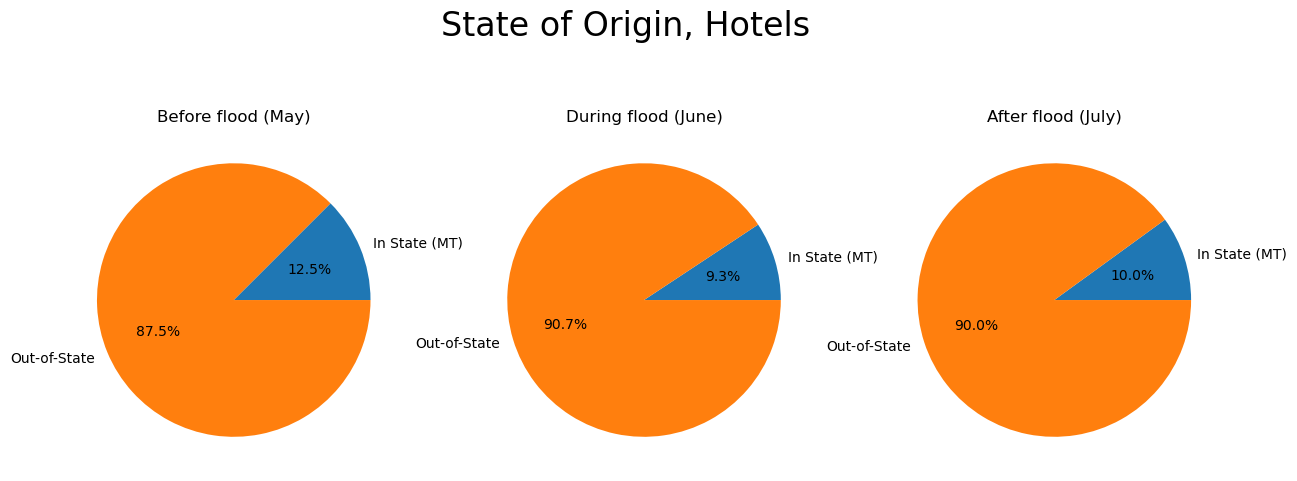

In [21]:
print('Before Flooding: ')
before = percent_instate(df_hotel_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_hotel_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_hotel_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Hotels', fontsize='24');

In [22]:
df_hotel_jan = time_filt(df_gardiner_hotels, month[0], month[1])
df_hotel_feb = time_filt(df_gardiner_hotels, month[1], month[2])
df_hotel_mar = time_filt(df_gardiner_hotels, month[2], month[3])
df_hotel_apr = time_filt(df_gardiner_hotels, month[3], month[4])
df_hotel_may = time_filt(df_gardiner_hotels, month[4], month[5])
df_hotel_jun = time_filt(df_gardiner_hotels, month[5], month[6])
df_hotel_jul = time_filt(df_gardiner_hotels, month[6], month[7])
df_hotel_aug = time_filt(df_gardiner_hotels, month[7], month[8])
df_hotel_sep = time_filt(df_gardiner_hotels, month[8], month[9])
df_hotel_oct = time_filt(df_gardiner_hotels, month[9], month[10])
df_hotel_nov = time_filt(df_gardiner_hotels, month[10], month[11])
df_hotel_dec = time_filt(df_gardiner_hotels, month[11], month[12])

hotel_dfs = [df_hotel_jan, df_hotel_feb, df_hotel_mar, df_hotel_apr, df_hotel_may, df_hotel_jun, 
             df_hotel_jul, df_hotel_aug, df_hotel_sep, df_hotel_oct, df_hotel_nov, df_hotel_dec]

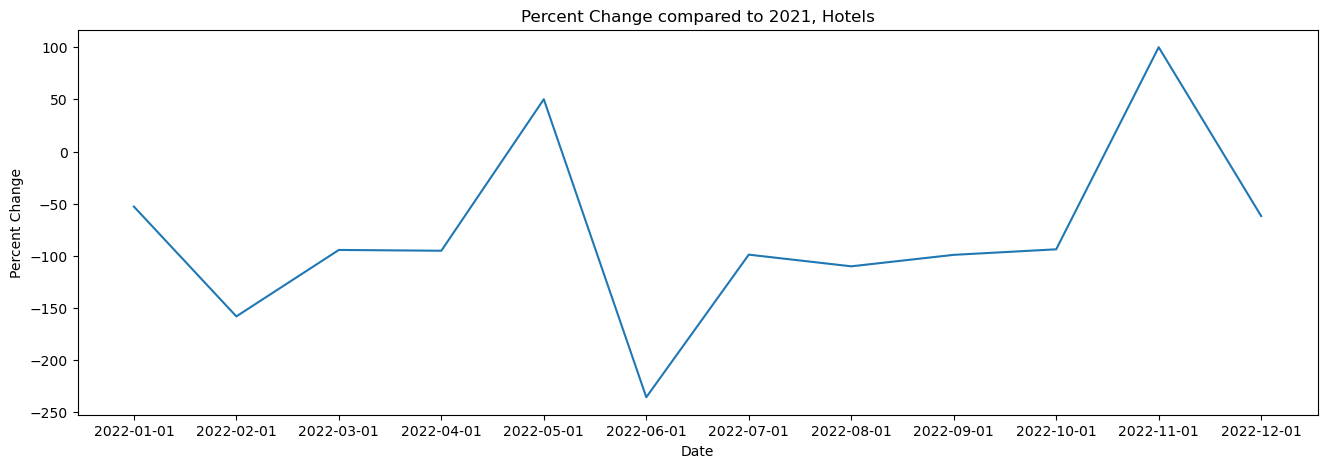

In [23]:
prev_year_pct=[]

for i in range(0, len(hotel_dfs)):
    prev_year_pct.append(percent_change_year(hotel_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Hotels');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

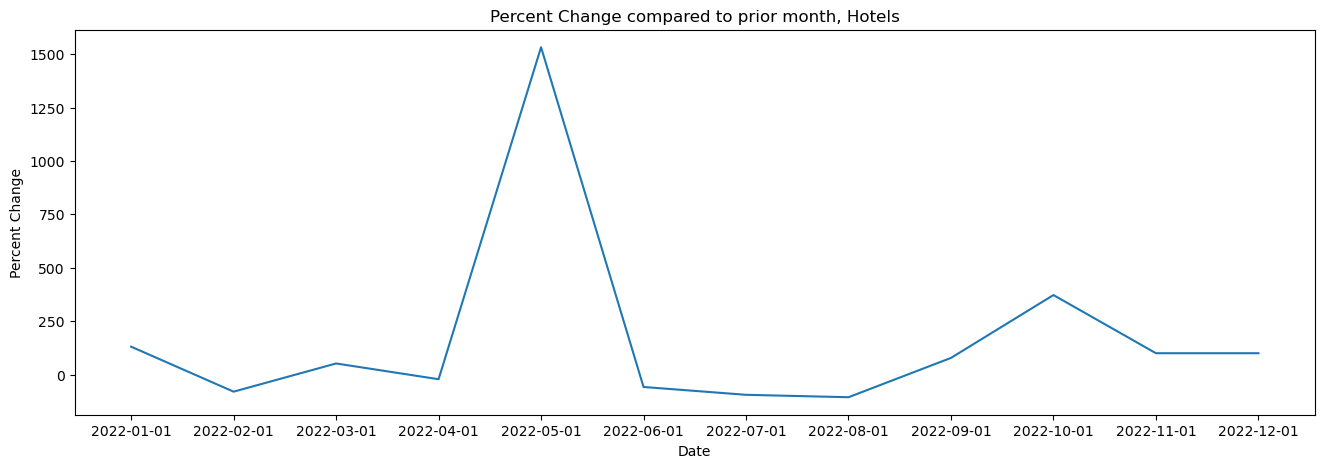

In [24]:
prev_month_pct=[]

for i in range(0, len(hotel_dfs)):
    prev_month_pct.append(percent_change_month(hotel_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Hotels');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Gardiner Food

In [25]:
food_naics = '722'
mask = [ str(ncode)[:3]==food_naics for ncode in list(df_gardiner_poi['NAICS_CODE']) ]
df_food_pois = df_gardiner_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_gardiner_food = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_food_pois['PLACEKEY'])]

df_food_before = time_filt(df_gardiner_food, before_flood_start, before_flood_end)
print(df_food_before.head(5), '\n')

df_food_during = time_filt(df_gardiner_food, during_flood_start, during_flood_end)
print(df_food_during.head(5), '\n')

df_food_after = time_filt(df_gardiner_food, after_flood_start, after_flood_end)
print(df_food_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND            TRANSACTION_INTERMEDIARY            SPEND_BY_TRANSACTION_INTERMEDIARY                   BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_

DATE
2022-06-03     350.56
2022-06-04     149.71
2022-06-05     516.01
2022-06-06    1476.32
2022-06-07     649.14
2022-06-08    1706.85
2022-06-09     254.58
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     680.50
2022-06-11     945.02
2022-06-12     884.76
2022-06-13    5158.10
2022-06-14     391.42
2022-06-15     106.19
2022-06-16      38.94
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    0.0
2022-06-18    0.0
2022-06-19    0.0
2022-06-20    0.0
2022-06-21    0.0
2022-06-22    0.0
2022-06-23    0.0
Name: SPEND_BY_DAY, dtype: float64


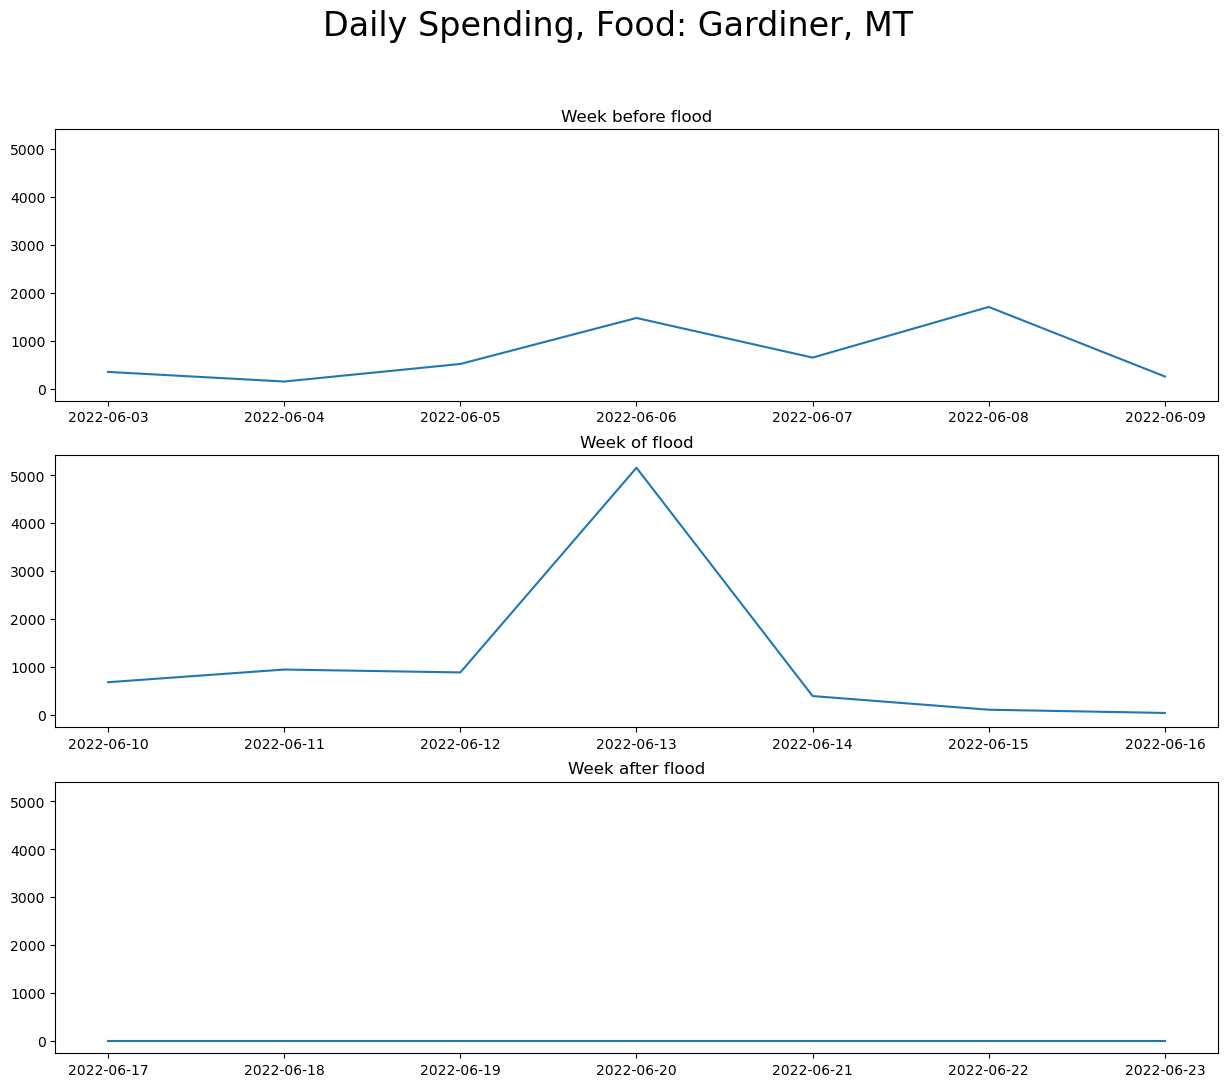

In [26]:
df_food_flood = time_filt(df_gardiner_food, '2022-05-01', '2022-08-01')
df_flood_spending_food = spend_by_day(df_food_flood)

before_flood_food = df_flood_spending_food[33:40]
during_flood_food = df_flood_spending_food[40:47]
after_flood_food = df_flood_spending_food[47:54]
print(before_flood_food)
print(during_flood_food)
print(after_flood_food)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_food)
ax1.set_title('Week before flood');
ax2.plot(during_flood_food)
ax2.set_title('Week of flood');
ax3.plot(after_flood_food)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Food: Gardiner, MT', fontsize='24');

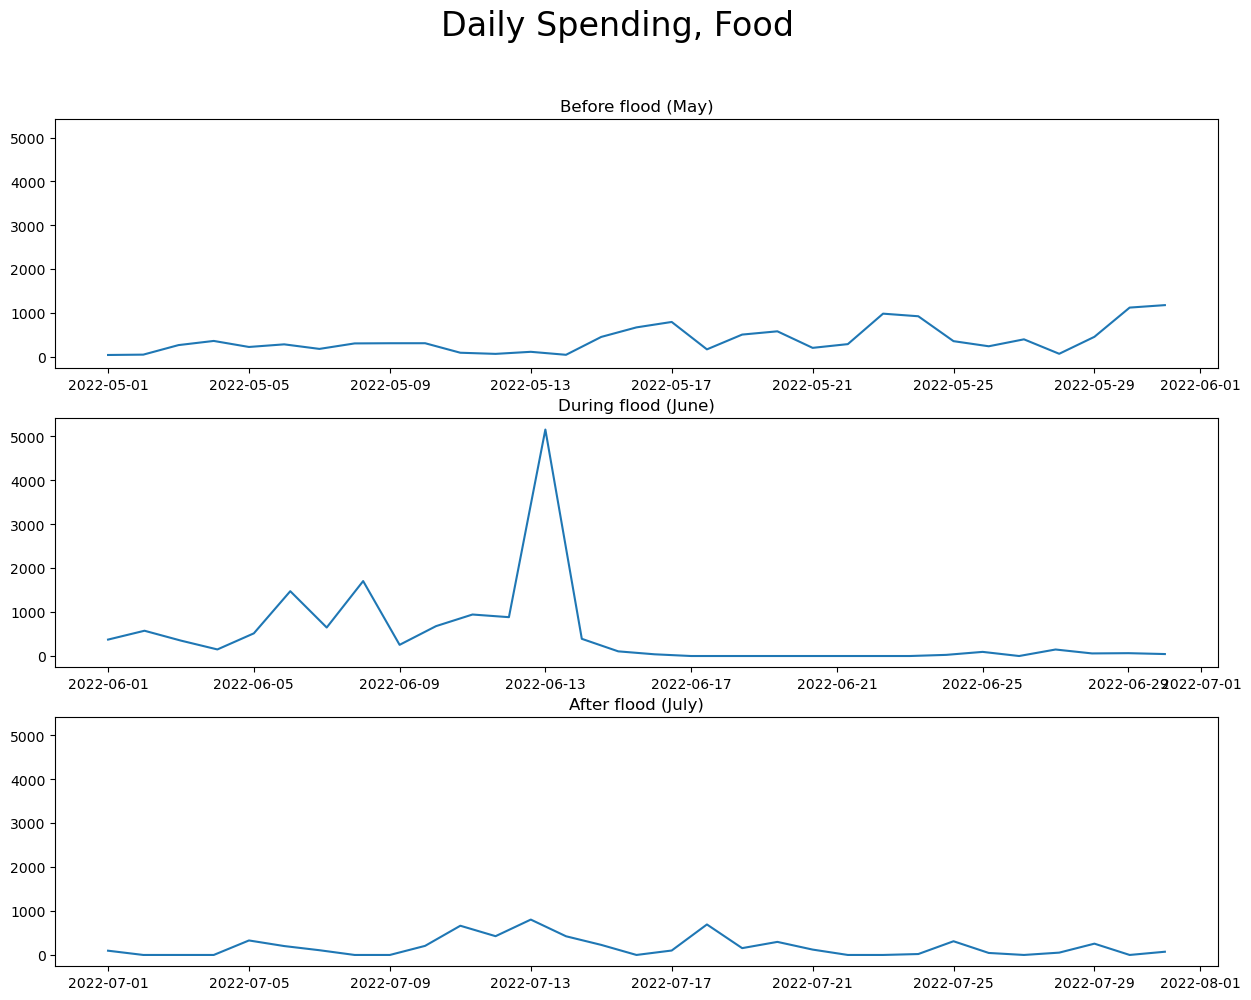

In [26]:
df_spend_before_food = spend_by_day(df_food_before)
df_spend_during_food = spend_by_day(df_food_during)
df_spend_after_food = spend_by_day(df_food_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_food)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_food)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_food)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Food', fontsize='24');

Before Flooding: 
Out of state:  361
In state:  23
Percentage out of state: 94.01041666666666 %


During Flooding: 
Out of state:  323
In state:  31
Percentage out of state: 91.24293785310734 %


After Flooding: 
Out of state:  80
In state:  23
Percentage out of state: 77.66990291262135 %




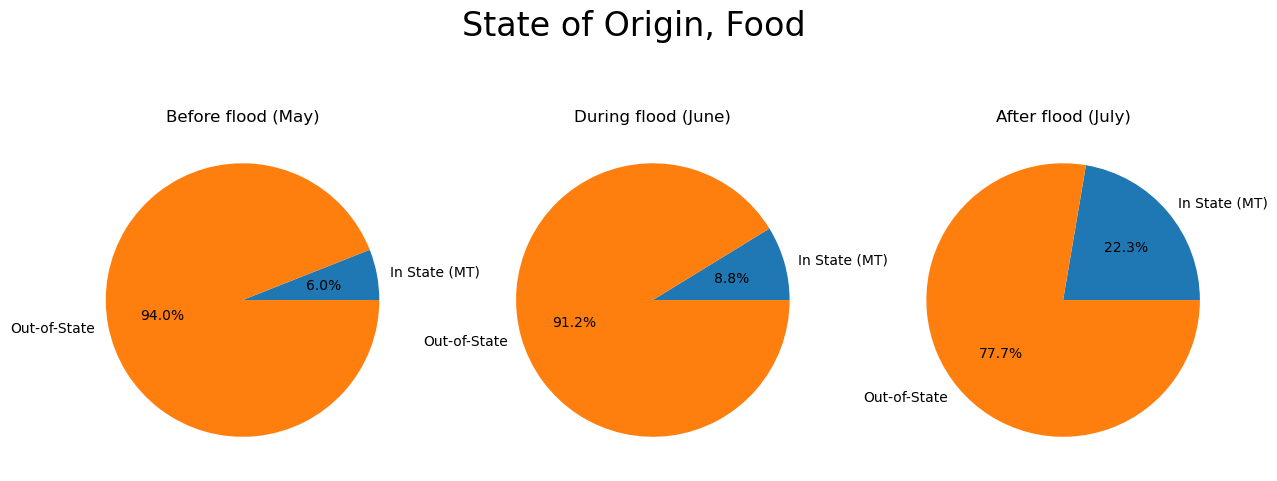

In [27]:
print('Before Flooding: ')
before = percent_instate(df_food_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_food_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_food_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Food', fontsize='24');

In [28]:
df_food_jan = time_filt(df_gardiner_food, month[0], month[1])
df_food_feb = time_filt(df_gardiner_food, month[1], month[2])
df_food_mar = time_filt(df_gardiner_food, month[2], month[3])
df_food_apr = time_filt(df_gardiner_food, month[3], month[4])
df_food_may = time_filt(df_gardiner_food, month[4], month[5])
df_food_jun = time_filt(df_gardiner_food, month[5], month[6])
df_food_jul = time_filt(df_gardiner_food, month[6], month[7])
df_food_aug = time_filt(df_gardiner_food, month[7], month[8])
df_food_sep = time_filt(df_gardiner_food, month[8], month[9])
df_food_oct = time_filt(df_gardiner_food, month[9], month[10])
df_food_nov = time_filt(df_gardiner_food, month[10], month[11])
df_food_dec = time_filt(df_gardiner_food, month[11], month[12])

food_dfs = [df_food_jan, df_food_feb, df_food_mar, df_food_apr, df_food_may, df_food_jun, 
             df_food_jul, df_food_aug, df_food_sep, df_food_oct, df_food_nov, df_food_dec]

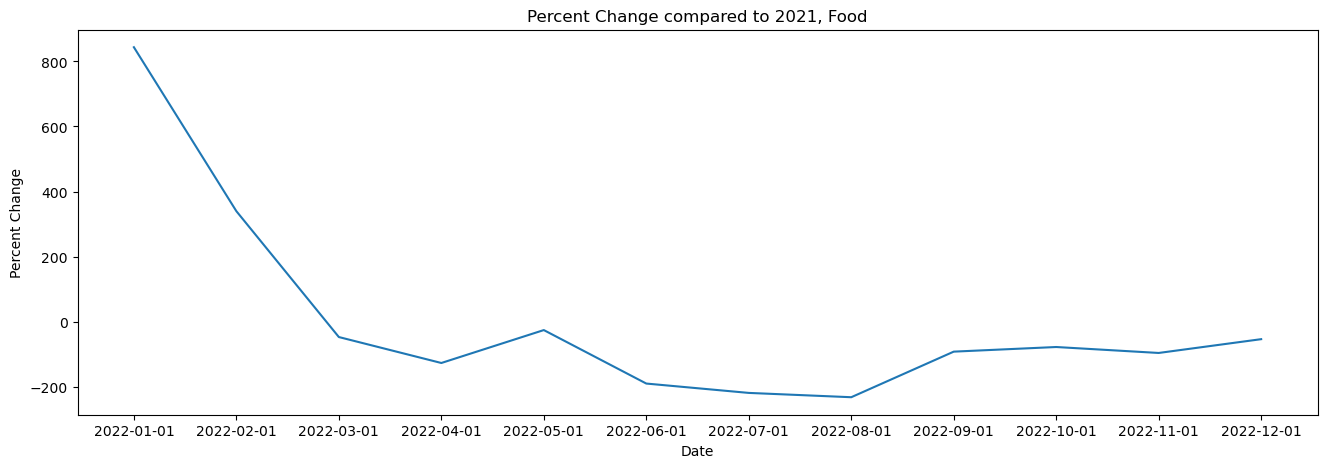

In [29]:
prev_year_pct=[]

for i in range(0, len(food_dfs)):
    prev_year_pct.append(percent_change_year(food_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Food');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

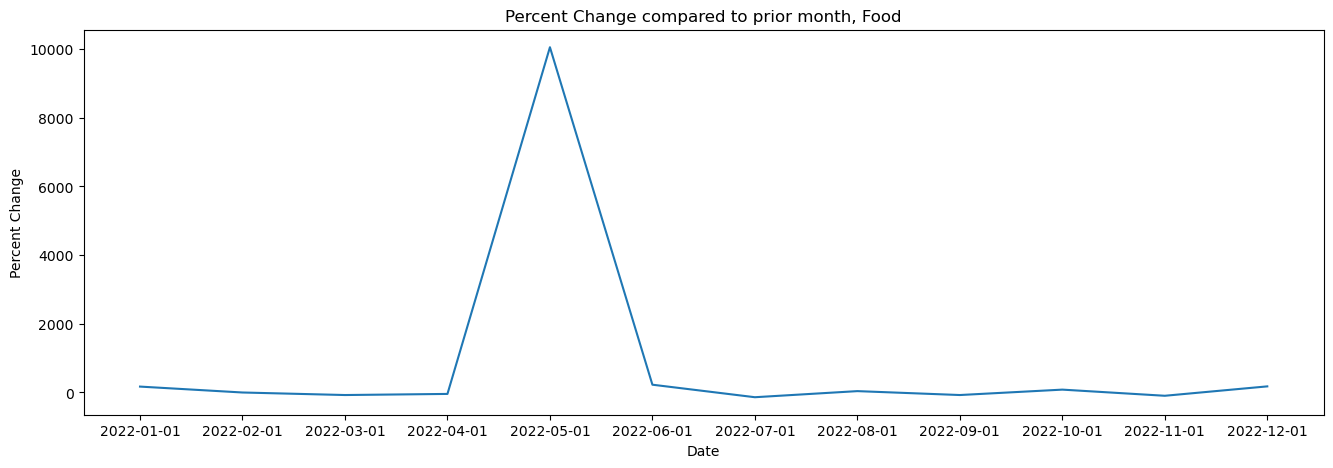

In [30]:
prev_month_pct=[]

for i in range(0, len(food_dfs)):
    prev_month_pct.append(percent_change_month(food_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Food');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Gardiner Retail

In [27]:
retail_naics = ['452', '445', '451', '448', '446', '711', '712', '713']
combined_mask = np.zeros(len(df_gardiner_poi),dtype=bool)
for i in retail_naics:
    mask = [ str(ncode)[:3]==i for ncode in list(df_gardiner_poi['NAICS_CODE']) ]
    combined_mask += mask
df_retail_poi = df_gardiner_poi[combined_mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_gardiner_retail = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_retail_poi['PLACEKEY'])]

df_retail_before = time_filt(df_gardiner_retail, before_flood_start, before_flood_end)
print(df_retail_before.head(5), '\n')

df_retail_during = time_filt(df_gardiner_retail, during_flood_start, during_flood_end)
print(df_retail_during.head(5), '\n')

df_retail_after = time_filt(df_gardiner_retail, after_flood_start, after_flood_end)
print(df_retail_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                     BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_SHOPPING_SAME_CATEGO

DATE
2022-06-03    879.30
2022-06-04    423.65
2022-06-05    227.26
2022-06-06    409.54
2022-06-07    603.12
2022-06-08    194.45
2022-06-09    351.92
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     361.01
2022-06-11     297.20
2022-06-12     907.87
2022-06-13    3579.50
2022-06-14     387.27
2022-06-15      98.72
2022-06-16     284.40
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    195.23
2022-06-18    196.34
2022-06-19     39.91
2022-06-20     70.04
2022-06-21     75.36
2022-06-22    103.05
2022-06-23    165.52
Name: SPEND_BY_DAY, dtype: float64


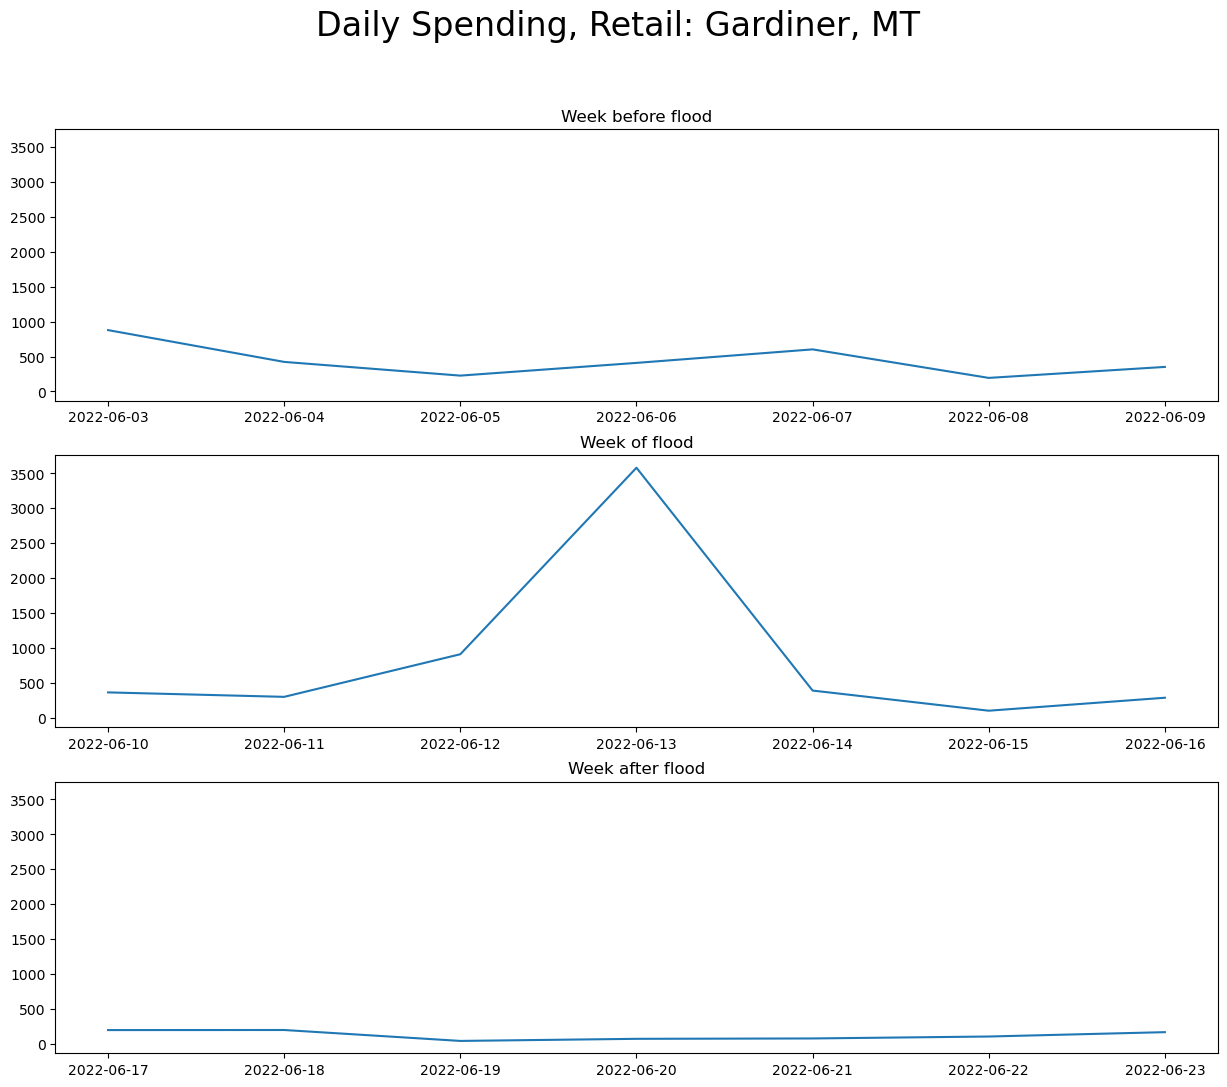

In [28]:
df_retail_flood = time_filt(df_gardiner_retail, '2022-05-01', '2022-08-01')
df_flood_spending_retail = spend_by_day(df_retail_flood)

before_flood_retail = df_flood_spending_retail[33:40]
during_flood_retail = df_flood_spending_retail[40:47]
after_flood_retail = df_flood_spending_retail[47:54]
print(before_flood_retail)
print(during_flood_retail)
print(after_flood_retail)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_retail)
ax1.set_title('Week before flood');
ax2.plot(during_flood_retail)
ax2.set_title('Week of flood');
ax3.plot(after_flood_retail)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Retail: Gardiner, MT', fontsize='24');

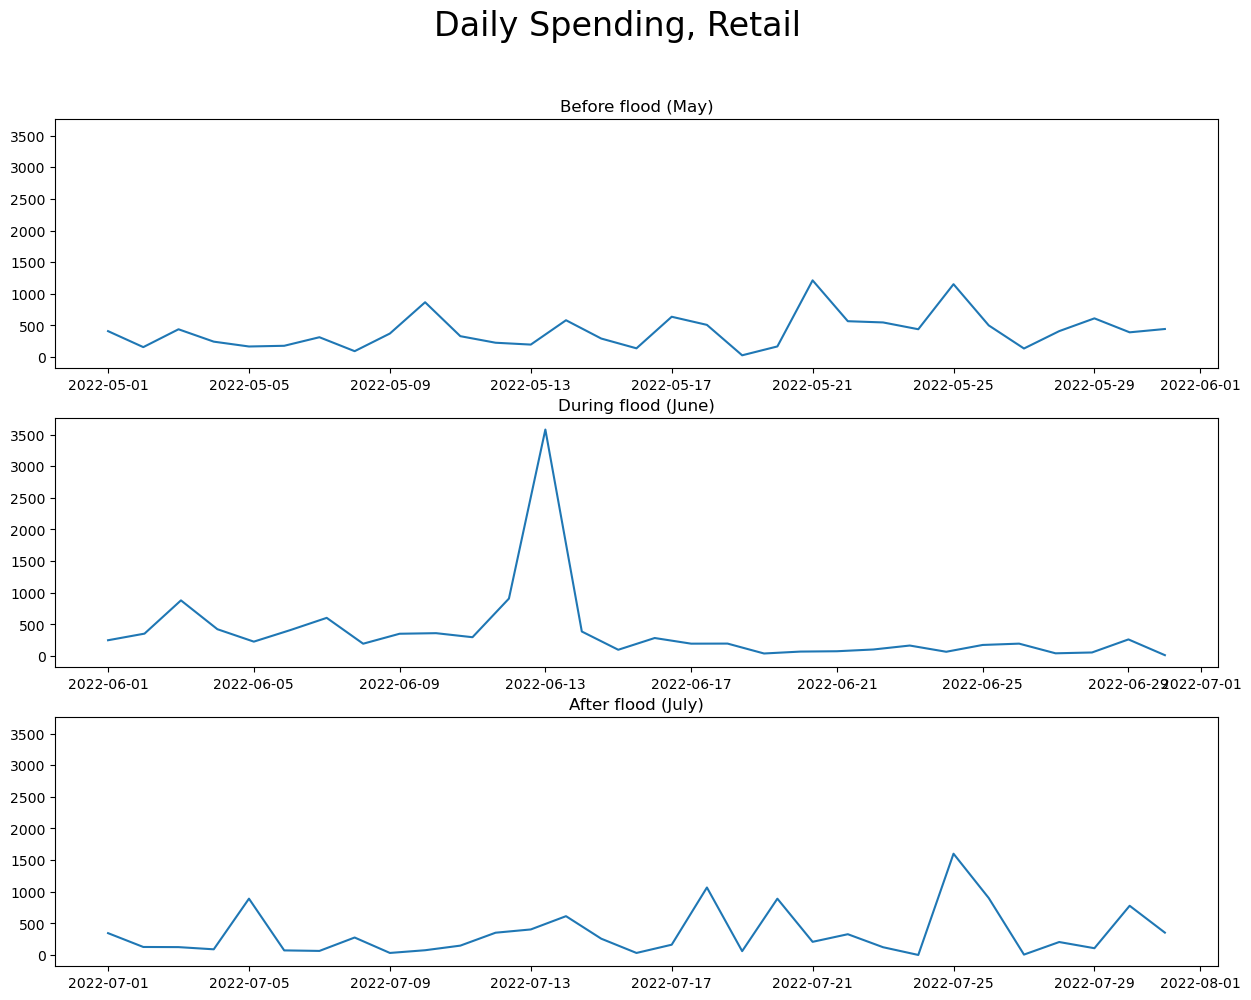

In [32]:
df_spend_before_retail = spend_by_day(df_retail_before)
df_spend_during_retail = spend_by_day(df_retail_during)
df_spend_after_retail = spend_by_day(df_retail_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_retail)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_retail)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_retail)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Retail', fontsize='24');

Before Flooding: 
Out of state:  192
In state:  27
Percentage out of state: 87.67123287671232 %


During Flooding: 
Out of state:  140
In state:  23
Percentage out of state: 85.88957055214725 %


After Flooding: 
Out of state:  64
In state:  21
Percentage out of state: 75.29411764705883 %




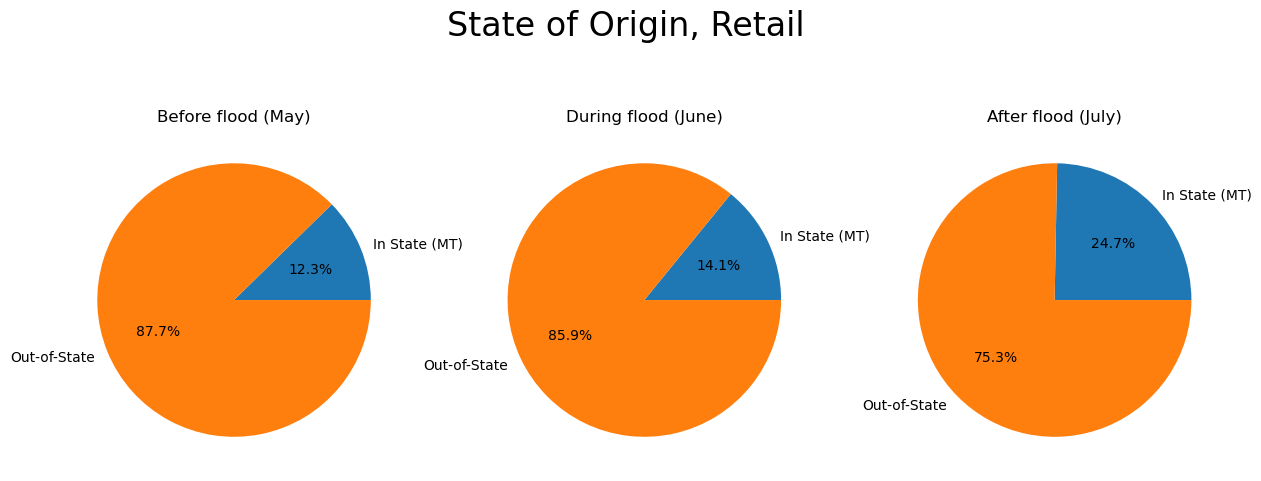

In [33]:
print('Before Flooding: ')
before = percent_instate(df_retail_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_retail_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_retail_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Retail', fontsize='24');

In [34]:
df_retail_jan = time_filt(df_gardiner_retail, month[0], month[1])
df_retail_feb = time_filt(df_gardiner_retail, month[1], month[2])
df_retail_mar = time_filt(df_gardiner_retail, month[2], month[3])
df_retail_apr = time_filt(df_gardiner_retail, month[3], month[4])
df_retail_may = time_filt(df_gardiner_retail, month[4], month[5])
df_retail_jun = time_filt(df_gardiner_retail, month[5], month[6])
df_retail_jul = time_filt(df_gardiner_retail, month[6], month[7])
df_retail_aug = time_filt(df_gardiner_retail, month[7], month[8])
df_retail_sep = time_filt(df_gardiner_retail, month[8], month[9])
df_retail_oct = time_filt(df_gardiner_retail, month[9], month[10])
df_retail_nov = time_filt(df_gardiner_retail, month[10], month[11])
df_retail_dec = time_filt(df_gardiner_retail, month[11], month[12])

retail_dfs = [df_retail_jan, df_retail_feb, df_retail_mar, df_retail_apr, df_retail_may, df_retail_jun, 
             df_retail_jul, df_retail_aug, df_retail_sep, df_retail_oct, df_retail_nov, df_retail_dec]

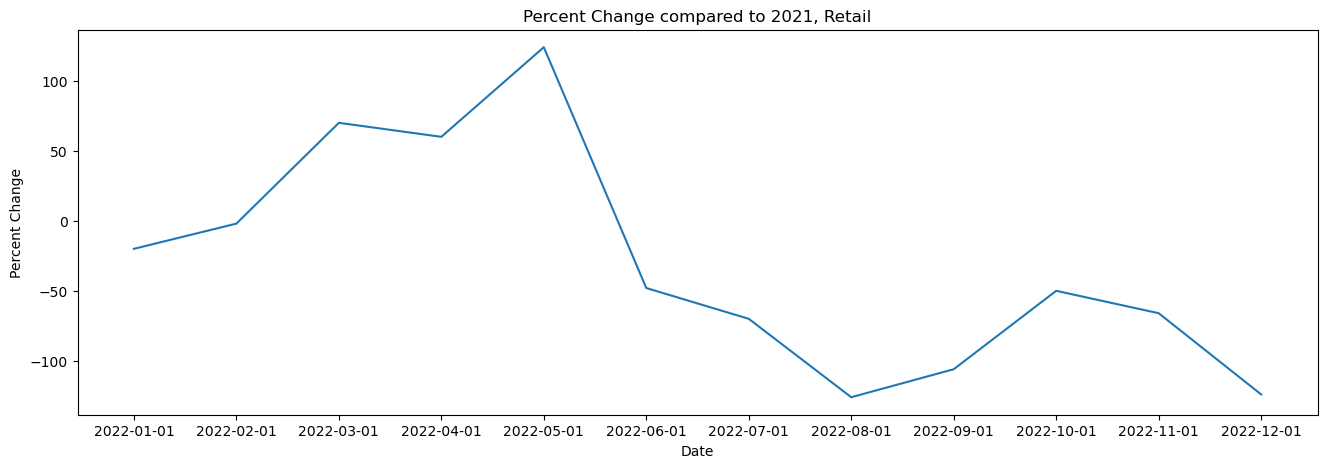

In [35]:
prev_year_pct=[]

for i in range(0, len(retail_dfs)):
    prev_year_pct.append(percent_change_year(retail_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Retail');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

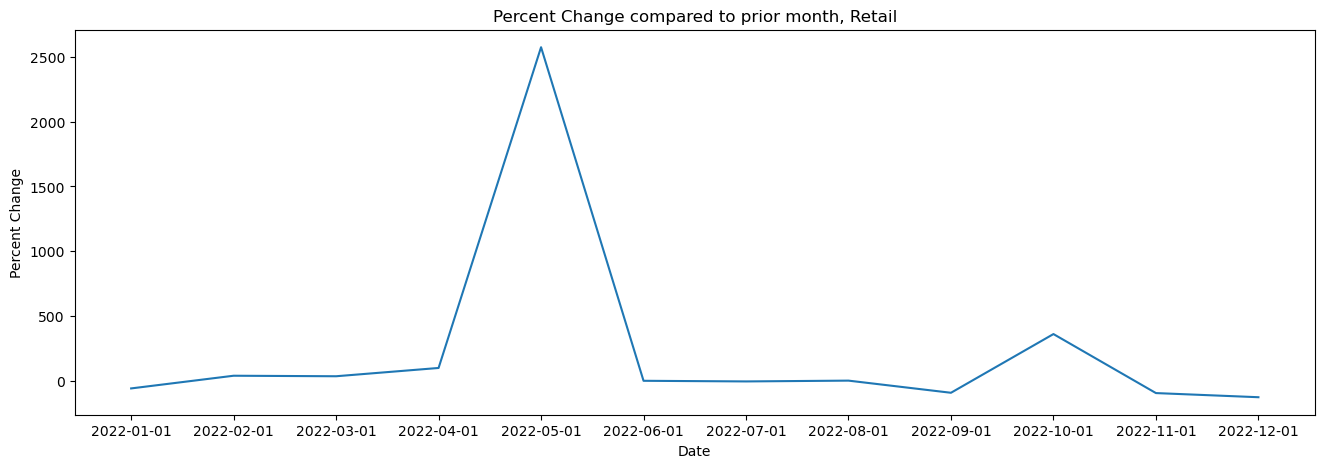

In [36]:
prev_month_pct=[]

for i in range(0, len(retail_dfs)):
    prev_month_pct.append(percent_change_month(retail_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Retail');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Gardiner Transportation

In [30]:
transit_naics = ['447', '485', '481']
combined_mask = np.zeros(len(df_gardiner_poi),dtype=bool)
for i in transit_naics:
    mask = [ str(ncode)[:3]==i for ncode in list(df_gardiner_poi['NAICS_CODE']) ]
    combined_mask += mask
df_transit_poi = df_gardiner_poi[combined_mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_gardiner_transit = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_transit_poi['PLACEKEY'])]

df_transit_before = time_filt(df_gardiner_transit, before_flood_start, before_flood_end)
print(df_transit_before.head(5), '\n')

df_transit_during = time_filt(df_gardiner_transit, during_flood_start, during_flood_end)
print(df_transit_during.head(5), '\n')

df_transit_after = time_filt(df_gardiner_transit, after_flood_start, after_flood_end)
print(df_transit_after.head(5), '\n')

                   PLACEKEY                        SAFEGRAPH_BRAND_IDS          BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                    BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    REL

DATE
2022-06-03    486.21
2022-06-04    442.92
2022-06-05    376.80
2022-06-06    659.87
2022-06-07    496.34
2022-06-08    679.92
2022-06-09    302.72
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    360.67
2022-06-11    463.49
2022-06-12    304.05
2022-06-13    662.02
2022-06-14    185.14
2022-06-15     35.86
2022-06-16      0.00
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    89.31
2022-06-18     0.00
2022-06-19     5.68
2022-06-20     3.98
2022-06-21    46.50
2022-06-22    23.84
2022-06-23     0.00
Name: SPEND_BY_DAY, dtype: float64


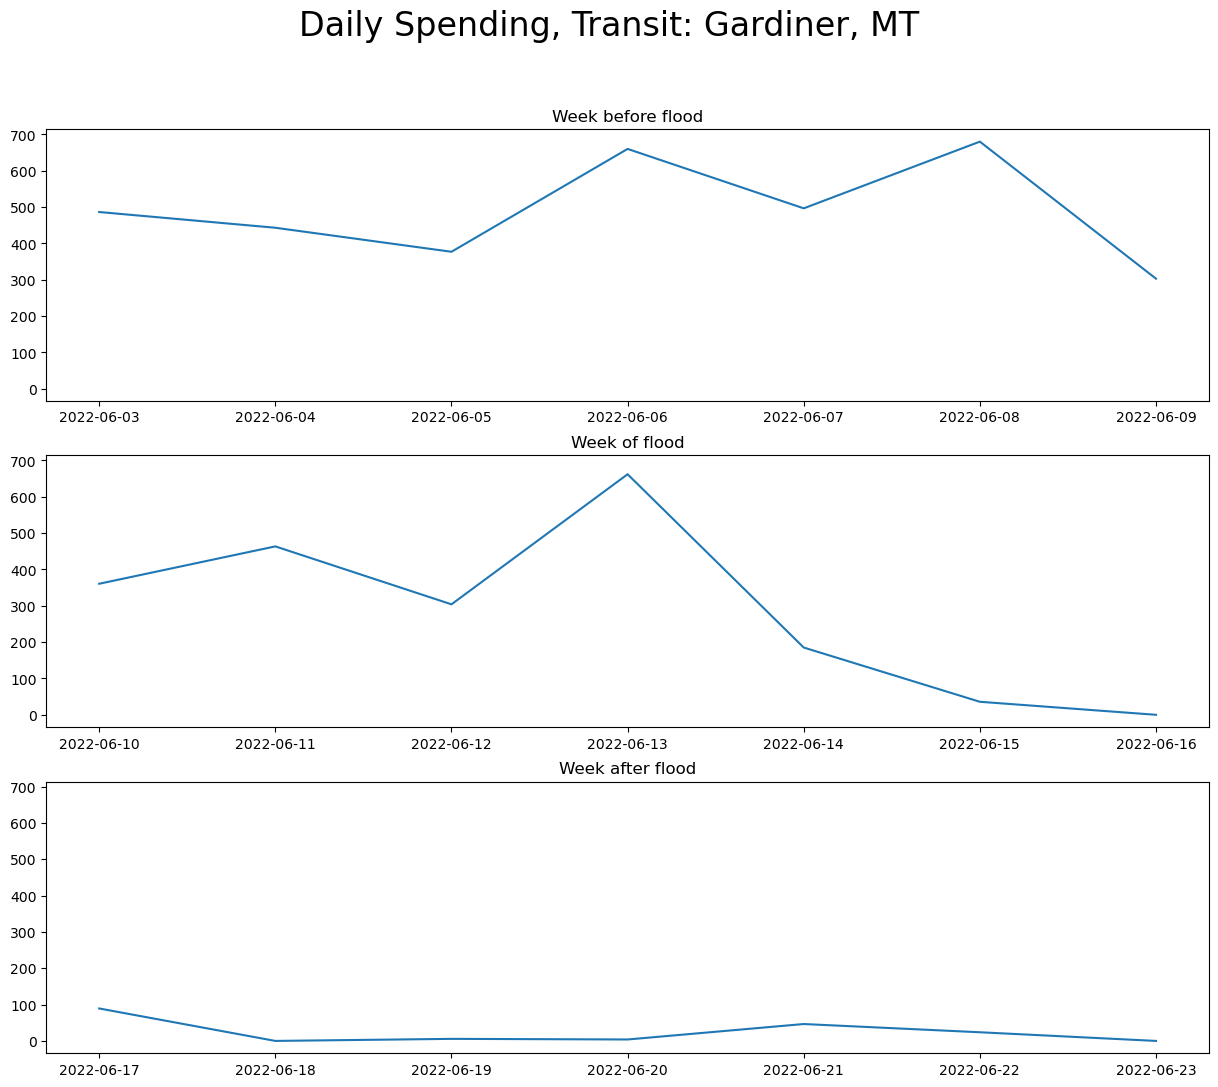

In [31]:
df_transit_flood = time_filt(df_gardiner_transit, '2022-05-01', '2022-08-01')
df_flood_spending_transit = spend_by_day(df_transit_flood)

before_flood_transit = df_flood_spending_transit[33:40]
during_flood_transit = df_flood_spending_transit[40:47]
after_flood_transit = df_flood_spending_transit[47:54]
print(before_flood_transit)
print(during_flood_transit)
print(after_flood_transit)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_transit)
ax1.set_title('Week before flood');
ax2.plot(during_flood_transit)
ax2.set_title('Week of flood');
ax3.plot(after_flood_transit)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Transit: Gardiner, MT', fontsize='24');

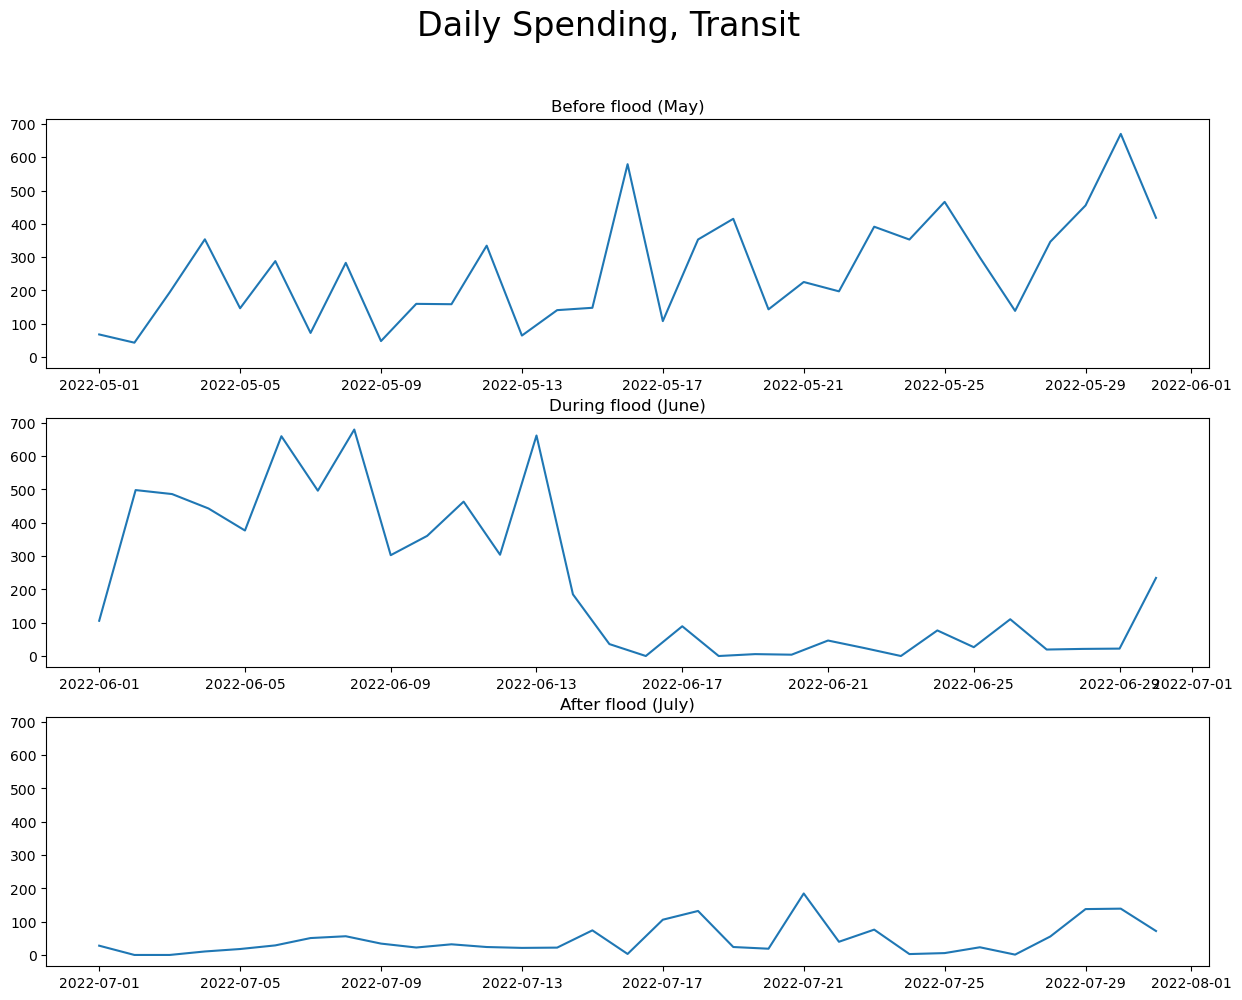

In [38]:
df_spend_before_transit = spend_by_day(df_transit_before)
df_spend_during_transit = spend_by_day(df_transit_during)
df_spend_after_transit = spend_by_day(df_transit_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_transit)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_transit)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_transit)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Transit', fontsize='24');

Before Flooding: 
Out of state:  254
In state:  22
Percentage out of state: 92.02898550724638 %


During Flooding: 
Out of state:  234
In state:  21
Percentage out of state: 91.76470588235294 %


After Flooding: 
Out of state:  37
In state:  12
Percentage out of state: 75.51020408163265 %




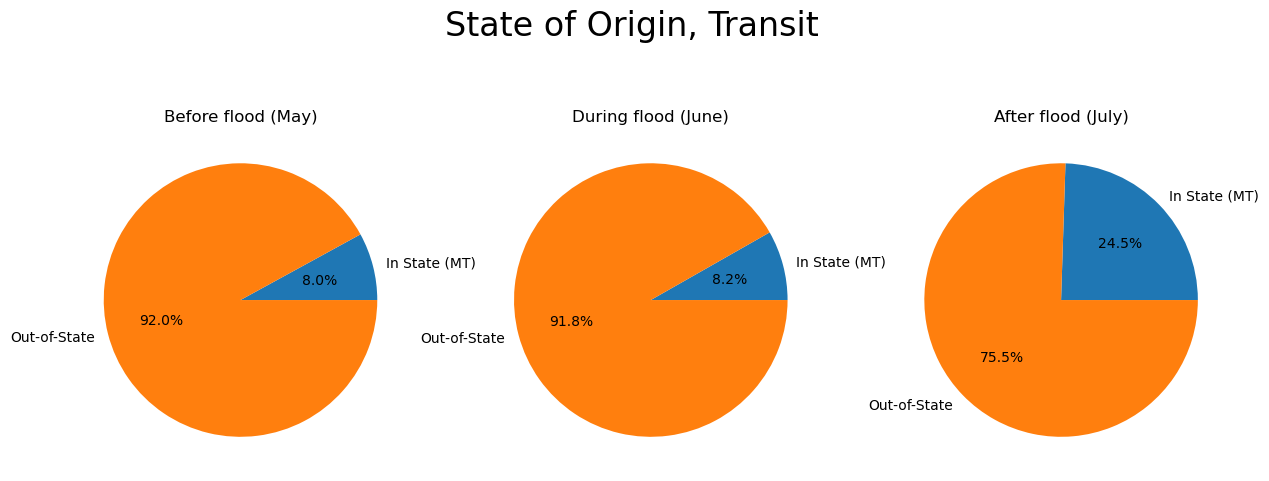

In [39]:
print('Before Flooding: ')
before = percent_instate(df_transit_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_transit_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_transit_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Transit', fontsize='24');

In [40]:
df_transit_jan = time_filt(df_gardiner_transit, month[0], month[1])
df_transit_feb = time_filt(df_gardiner_transit, month[1], month[2])
df_transit_mar = time_filt(df_gardiner_transit, month[2], month[3])
df_transit_apr = time_filt(df_gardiner_transit, month[3], month[4])
df_transit_may = time_filt(df_gardiner_transit, month[4], month[5])
df_transit_jun = time_filt(df_gardiner_transit, month[5], month[6])
df_transit_jul = time_filt(df_gardiner_transit, month[6], month[7])
df_transit_aug = time_filt(df_gardiner_transit, month[7], month[8])
df_transit_sep = time_filt(df_gardiner_transit, month[8], month[9])
df_transit_oct = time_filt(df_gardiner_transit, month[9], month[10])
df_transit_nov = time_filt(df_gardiner_transit, month[10], month[11])
df_transit_dec = time_filt(df_gardiner_transit, month[11], month[12])

transit_dfs = [df_transit_jan, df_transit_feb, df_transit_mar, df_transit_apr, df_transit_may, df_transit_jun, 
             df_transit_jul, df_transit_aug, df_transit_sep, df_transit_oct, df_transit_nov, df_transit_dec]

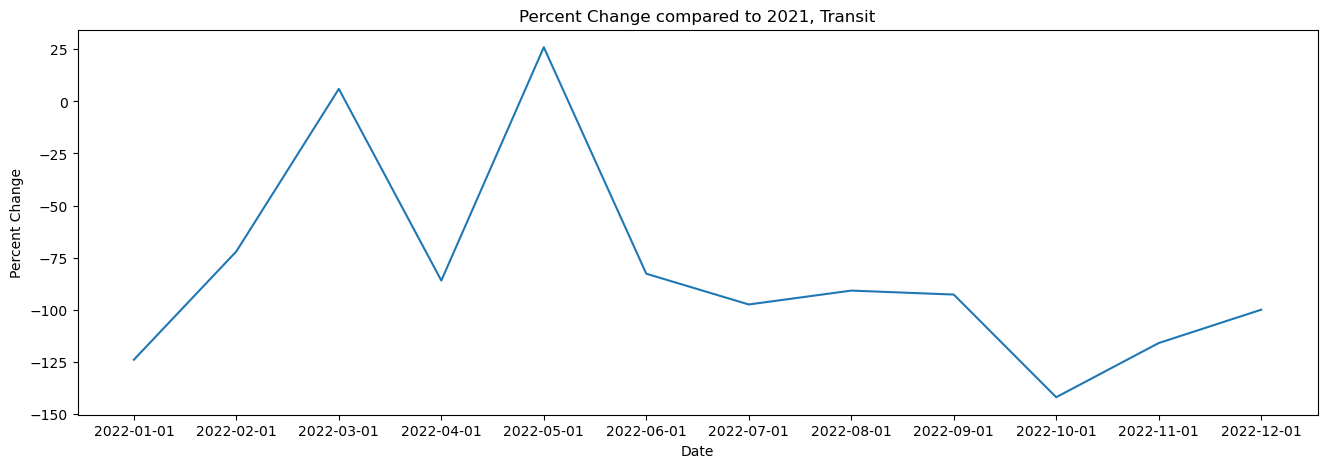

In [41]:
prev_year_pct=[]

for i in range(0, len(transit_dfs)):
    prev_year_pct.append(percent_change_year(transit_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Transit');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

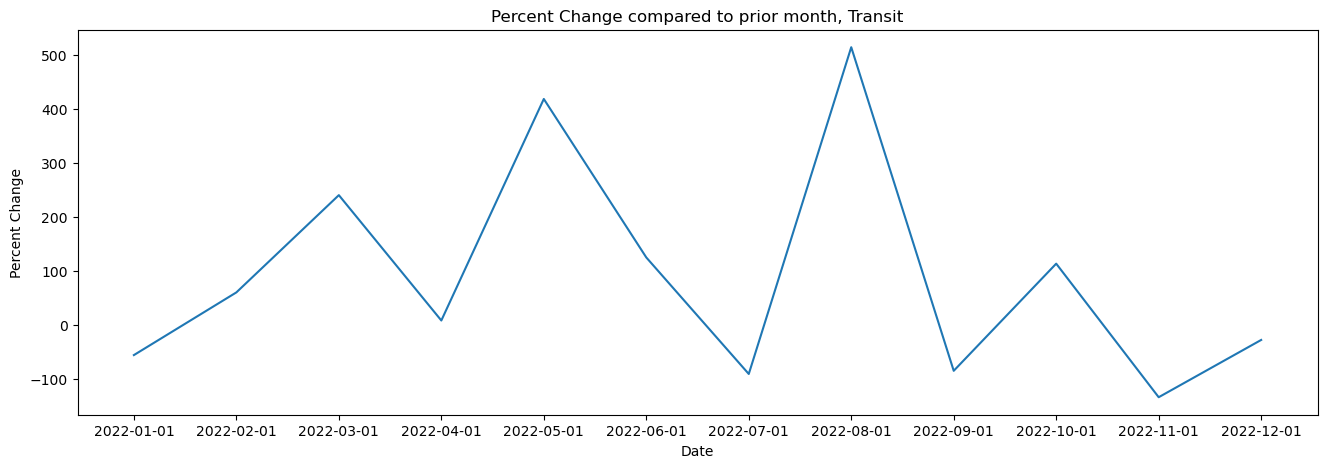

In [42]:
prev_month_pct=[]

for i in range(0, len(transit_dfs)):
    prev_month_pct.append(percent_change_month(transit_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Transit');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Aggregate 

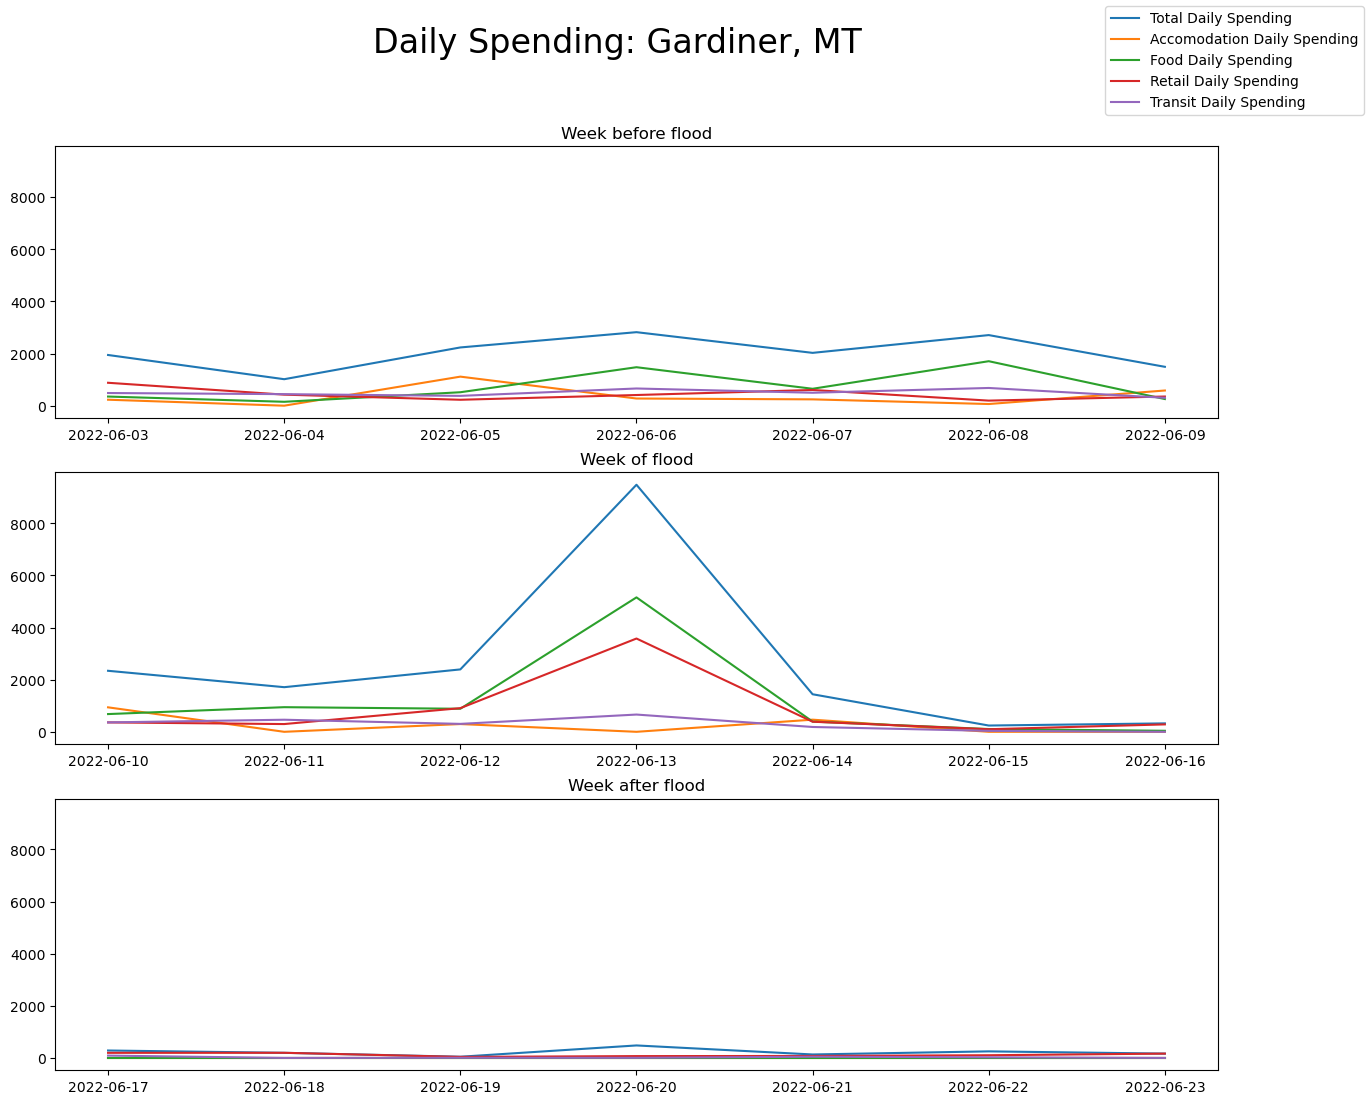

In [36]:
fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood, label='Total Daily Spending')
ax1.plot(before_flood_hotels, label='Accomodation Daily Spending');
ax1.plot(before_flood_food, label='Food Daily Spending')
ax1.plot(before_flood_retail, label='Retail Daily Spending')
ax1.plot(before_flood_transit, label='Transit Daily Spending')
ax1.set_title('Week before flood');
ax2.plot(during_flood)
ax2.plot(during_flood_hotels)
ax2.plot(during_flood_food)
ax2.plot(during_flood_retail)
ax2.plot(during_flood_transit)
ax2.set_title('Week of flood');
ax3.plot(after_flood)
ax3.plot(after_flood_hotels)
ax3.plot(after_flood_food)
ax3.plot(after_flood_retail)
ax3.plot(after_flood_transit)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending: Gardiner, MT', fontsize='24');
fig.legend();